# SVM и его ядра
__Суммарное количество баллов: 9__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW07] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании нам предстоит решить задачу SVM при помощи `cvxopt` и применить ее к искуственным данным. Затем аналогичным способом нужно будет решить задачу ядерного SVM и исследовать его поведение для различных ядер и значений их параметров.

In [1]:
import numpy as np
import copy
from cvxopt import spmatrix, matrix, solvers
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_blobs
from typing import NoReturn, Callable

solvers.options['show_progress'] = False

In [9]:
def visualize(clf, X, y):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_border = (x_max - x_min) / 20 + 1.0e-3
    x_h = (x_max - x_min + 2 * x_border) / 200
    y_border = (y_max - y_min) / 20 + 1.0e-3
    y_h = (y_max - y_min + 2 * y_border) / 200

    cm = plt.cm.Spectral

    xx, yy = np.meshgrid(np.arange(x_min - x_border, x_max + x_border, x_h),
                         np.arange(y_min - y_border, y_max + y_border, y_h))
    mesh = np.c_[xx.ravel(), yy.ravel()]

    z_class = clf.predict(mesh).reshape(xx.shape)

    # Put the result into a color plot
    plt.figure(1, figsize=(8, 8))
    plt.pcolormesh(xx, yy, z_class, cmap=cm, alpha=0.3, shading='gouraud')

    # Plot hyperplane and margin
    z_dist = clf.decision_function(mesh).reshape(xx.shape)
    plt.contour(xx, yy, z_dist, [0.0], colors='black')
    plt.contour(xx, yy, z_dist, [-1.0, 1.0], colors='black', linestyles='dashed')

    # Plot also the training points
    y_pred = clf.predict(X)

    ind_support = clf.support.flatten()
    ind_correct = []
    ind_incorrect = []
    for i in range(len(y)):
        # if i in clf.support:
        #     ind_support.append(i)
        if y[i] == y_pred[i]:
            ind_correct.append(i)
        else:
            ind_incorrect.append(i)

    plt.scatter(X[ind_correct, 0], X[ind_correct, 1], c=y[ind_correct], cmap=cm, alpha=1., edgecolor='black',
                linewidth=.8)
    plt.scatter(X[ind_incorrect, 0], X[ind_incorrect, 1], c=y[ind_incorrect], cmap=cm, alpha=1., marker='*',
                s=50, edgecolor='black', linewidth=.8)
    plt.scatter(X[ind_support, 0], X[ind_support, 1], c=y[ind_support], cmap=cm, alpha=1., edgecolor='yellow',
                linewidths=1.,
                s=40)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tight_layout()

In [3]:
def generate_dataset(moons=False):
    if moons:
        X, y = make_moons(1000, noise=0.075, random_state=42)
        return X, 2 * y - 1
    X, y = make_blobs(1000, 2, centers=[[0, 0], [-4, 2], [3.5, -2.0], [3.5, 3.5]], random_state=42)
    y = 2 * (y % 2) - 1
    return X, y

X, y = generate_dataset(True)

### Задание 1 (2 балла)
Для начала реализуем обычный линейный SVM. 

#### Методы
`fit(X, y)` - обучает SVM, решая задачу оптимизации при помощи `cvxopt.solvers.qp`

`decision_function(X)` - возвращает значение решающей функции (т.е. то число, от которого берем знак с целью узнать класс)

#### Поля
`support` - индексы опорных элементов

### Решение с помощью QP Solver

QP-solver решает такую задачу:

$\begin{cases}0.5 \cdot x^\text{T}Px + q^\text{T}x\rightarrow \min_x\\Gx \leq h\\Ax=b\end{cases}$

А наша задача формулируется так:

$\begin{cases}0.5 \cdot w^\text{T}w + C \cdot \sum \xi_i \rightarrow \min_{w, \xi} \\ \xi \geq 0 \\ y_i (w^\text{T}x_i + w_0) \geq 1 - \xi_i \end{cases}$

Сведем ее к задаче QP-solver'а:

$ x = (w, w_0, \xi) \\ P = 
\left[
    \begin{array}{c|c}
      I & 0\\
      \hline
      0 & 0
    \end{array}
\right] \\ 
q = \left[
    \begin{array}{c}
      0 \\
      \hline
      C 
    \end{array}
\right] \\ 
 G = 
\left[
    \begin{array}{c|c|c}
      0 & 0 & -I\\
      \hline
      -yX & -y & -I
    \end{array}
\right] \\ h = \left[
    \begin{array}{c}
      0 \\
      \hline
      -1 
    \end{array}
\right] $

In [4]:
class LinearSVM:
    def __init__(self, C: float):
        """

        Parameters
        ----------
        C : float
            Soft margin coefficient.

        """
        self.C = C
        self.support = None
        self.x = np.ndarray

    def find_support(self, X):
        res = X @ self.w + self.w0
        self.support = abs(abs(res) - 1) < 1e-8

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает SVM, решая задачу оптимизации при помощи cvxopt.solvers.qp

        Parameters
        ----------
        X : np.ndarray
            Данные для обучения SVM.
        y : np.ndarray
            Бинарные метки классов для элементов X
            (можно считать, что равны -1 или 1).

        """
        y = y.reshape(-1, 1)
        n, m = X.shape
        w = np.random.randn(m + 1)
        ksi = np.random.randn(n)

        x = np.hstack([w, ksi])
        P = np.block([
            [np.eye(m), np.zeros(shape=(m, n + 1))],
            [np.zeros(shape=(n + 1, m)), np.zeros(shape=(n + 1, n + 1))]
        ])
        q = np.hstack([np.zeros(m + 1), self.C * np.ones(n)])
        h = np.hstack([np.zeros(n), -np.ones(n)])
        G = np.block([
            [np.zeros((n, m)), np.zeros((n, 1)), -np.eye(n)],
            [-y * X,         -y,             -np.eye(n)]
        ])
        res = solvers.qp(matrix(P),
                         matrix(q),
                         matrix(G),
                         matrix(h))
        self.w = res['x'][:m]
        self.w0 = res['x'][m]

        # support_ind = res['x'][m:] > 1e-6
        # self.support = np.array(res['z'])[n:] > 1e-6

        self.find_support(X)

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        """
        Возвращает значение решающей функции.

        Parameters
        ----------
        X : np.ndarray
            Данные, для которых нужно посчитать значение решающей функции.

        Return
        ------
        np.ndarray
            Значение решающей функции для каждого элемента X
            (т.е. то число, от которого берем знак с целью узнать класс).

        """
        return X @ self.w + self.w0

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Классифицирует элементы X.

        Parameters
        ----------
        X : np.ndarray
            Данные, которые нужно классифицировать

        Return
        ------
        np.ndarray
            Метка класса для каждого элемента X.

        """
        return np.sign(self.decision_function(X))


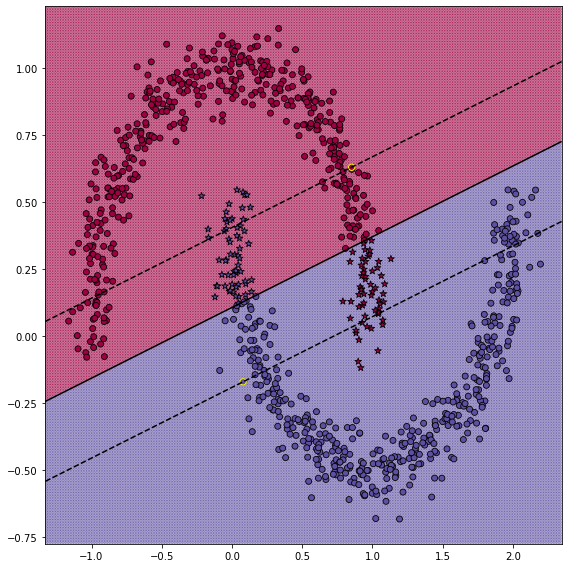

In [10]:
X, y = generate_dataset(True)
svm = LinearSVM(1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

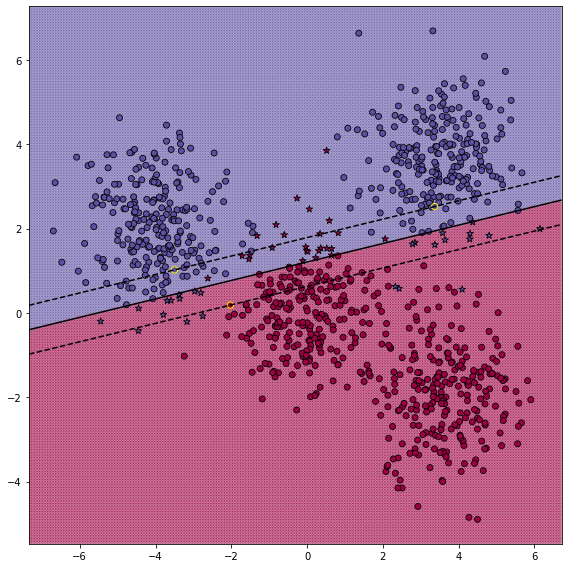

In [11]:
X, y = generate_dataset(False)
svm = LinearSVM(1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

### Задание 2 (2 балла)
Перед реализацией ядерного SVM, реализуем функции, которые строят ядра.

#### Описание
`get_polynomial_kernel(power)` - возвращает полиномиальное ядро с заданной константой и степенью

`get_gaussian_kernel(sigma=1.)` - возвращает ядро Гаусса с заданным коэффицинтом сигма

In [ ]:
def get_polynomial_kernel(c=1, power=2):
    """Возвращает полиномиальное ядро с заданной константой и степенью"""
    return lambda u, v: (c + u @ v) ** power


def get_gaussian_kernel(sigma=1.):
    """Возвращает ядро Гаусса с заданным коэффицинтом сигма"""
    return lambda u, v: np.exp(-sigma * (u - v) @ (u - v))

### Задание 3 (2 балла)
Теперь перейдем к реализации самого kernel SVM.

#### Описание
`fit(X, y)` - обучает kernel SVM, решая задачу оптимизации при помощи `cvxopt.solvers.qp`

`decision_function(X)` - возвращает значение решающей функции (т.е. то число, от которого берем знак с целью узнать класс)

#### Конструктор
`kernel` - ядро-функция

### Решение с помощью QP Solver

QP-solver решает такую задачу:

$\begin{cases}0.5 \cdot x^\text{T}Px + q^\text{T}x\rightarrow \min_x\\Gx \leq h\\Ax=b\end{cases}$

Будем решать двойственную задачу. Формулируется она так:

$\begin{cases}\sum \alpha_i - 0.5 \sum \alpha_i \alpha_j y_i y_j K(x_i, x_j) \rightarrow \max_{\alpha}\\ C \geq \alpha \geq 0 \\ y_i \alpha = 0 \end{cases}$

Сведем ее к задаче QP-solver'а:

$ x = \alpha \\ P = 
\left[ y_i y_j K(y_i, y_j) \right] \\ 
q = \left[ -1
\right] \\ 
 G = 
\left[
    \begin{array}{c}
      I\\
      \hline
      -I
    \end{array}
\right] \\ h = \left[
    \begin{array}{c}
      C \\
      \hline
      0 
    \end{array}
\right] \\
b = 0\\
A = y^\text{T}$

В таком случае решающей функцией будет:

$a(x) = \text{sign} (\sum \alpha_i y_i K(x, x_i) + w_0)$, где $w_0 = \frac{1}{n}\sum\limits_{i=1}^{n}[y_i - \sum \alpha_j y_j K(x_i, x_j)]$

In [ ]:
class KernelSVM:
    def __init__(self, C: float, kernel: Callable = linear_kernel):
        """
        
        Parameters
        ----------
        C : float
            Soft margin coefficient.
        kernel : Callable
            Функция ядра.
        
        """
        self.C = C
        self.kernel = kernel
        self.support = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает SVM, решая задачу оптимизации при помощи cvxopt.solvers.qp
        
        Parameters
        ----------
        X : np.ndarray
            Данные для обучения SVM.
        y : np.ndarray
            Бинарные метки классов для элементов X 
            (можно считать, что равны -1 или 1). 
        
        """
        pass

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        """
        Возвращает значение решающей функции.
        
        Parameters
        ----------
        X : np.ndarray
            Данные, для которых нужно посчитать значение решающей функции.

        Return
        ------
        np.ndarray
            Значение решающей функции для каждого элемента X 
            (т.е. то число, от которого берем знак с целью узнать класс).     
        
        """
        pass

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Классифицирует элементы X.
        
        Parameters
        ----------
        X : np.ndarray
            Данные, которые нужно классифицировать

        Return
        ------
        np.ndarray
            Метка класса для каждого элемента X.   
        
        """
        return np.sign(self.decision_function(X))

In [ ]:
X, y = generate_dataset(True)
svm = KernelSVM(1, kernel=get_polynomial_kernel(1, 3))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

In [ ]:
X, y = generate_dataset(False)
svm = KernelSVM(1, kernel=get_polynomial_kernel(1, 3))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

In [ ]:
X, y = generate_dataset(True)
svm = KernelSVM(1, kernel=get_gaussian_kernel(0.4))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

In [ ]:
X, y = generate_dataset(False)
svm = KernelSVM(1, kernel=get_gaussian_kernel(0.4))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

### Задание 4 (3 балла)
Исследуйте и опишите влияние параметров каждого вида ядра на полученный классификатор. Что происходит при увеличении константы в полиномиальном ядре? При увеличении степени? Как влияет на результат сигма в ядре Гаусса?

__При выполнении этого задания стоит написать код, который визуализирует классификаторы с различными ядрами__